# Facility Location for temporal markets using PuLP and UrbanPy

### General imports

In [2]:
import sys
sys.path.append('..')
import urbanpy as up
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
import re
from pulp import *

### Data preparation

First, we need our set of possible facilities to activate. To construct it we will

* Download a polygon from a Lima district
* Get its bounds
* Download data from possible parks and pitches

In [3]:
sjl = up.download.nominatim_osm('San Juan de Lurigancho, Lima')
sjl.crs = 'EPSG:4326'

Now we are going to create a custom query for the overpass api to download parks an pitches within the district polygon. You can try your own cutom querys [here](https://overpass-turbo.eu/).

In [4]:
query = """
[timeout:120][out:json][bbox];
(
  way["leisure"~"park|pitch"];
);
out body geom;
"""
response = up.download.overpass_pois(sjl.total_bounds, custom_query=query)

Now, we are going to create a GeoDataFrame using the query results

In [5]:
data = response.json() # get json data
parks_pitchs_df = pd.DataFrame.from_dict(data['elements']) # transform data to dataframe

`shell_from_geometry` is a helper function to create the input for a Polygon using the overpass geometry

In [6]:
parks_pitchs_df['shell'] = parks_pitchs_df['geometry'].apply(up.utils.shell_from_geometry)

Use the generated shell to instanciate a Polygon for each row

In [7]:
parks_pitchs_geometry = parks_pitchs_df['shell'].apply(shapely.geometry.Polygon)

Create a GeoDataFrame using the DataFrame and the calculated geometry

In [8]:
parks_pitchs_gdf = gpd.GeoDataFrame(parks_pitchs_df, geometry=parks_pitchs_geometry)

We need to process the polygon data, getting the centroid is a good approximation

In [9]:
parks_pitchs_gdf.crs = 'EPSG:4326'
parks_pitchs_gdf['area'] = parks_pitchs_gdf.to_crs(epsg=32718).geometry.area

In [10]:
parks_pitchs_gdf['lat'] = parks_pitchs_gdf.geometry.centroid.y
parks_pitchs_gdf['lon'] = parks_pitchs_gdf.geometry.centroid.x

/home/claudio/Documents/urbanpy/.env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/home/claudio/Documents/urbanpy/.env/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


Construct the candidate set from Overpass POIs

In [11]:
candidates = parks_pitchs_gdf[['id', 'lat', 'lon', 'area']]
candidates = gpd.GeoDataFrame(candidates, geometry=gpd.points_from_xy(candidates['lon'], candidates['lat']))
candidates.crs = 'EPSG:4326'

In [12]:
candidates['aforo'] = candidates['area'] * 2

In [13]:
candidates.head()

,id,lat,lon,area,geometry,aforo
0,67624202,-11.985354,-77.014213,2841.493813,POINT (-77.01421 -11.98535),5682.987625
1,67624203,-11.985472,-77.014529,508.268924,POINT (-77.01453 -11.98547),1016.537847
2,67624204,-11.985366,-77.014138,11286.055353,POINT (-77.01414 -11.98537),22572.110706
3,67626150,-11.986800,-77.010059,553.973269,POINT (-77.01006 -11.98680),1107.946537
4,67626151,-11.986273,-77.009586,3281.189031,POINT (-77.00959 -11.98627),6562.378062


### Concatenating candidates with the national market census

In [14]:
markets = pd.read_csv('input/market_db.csv')
markets = gpd.GeoDataFrame(markets, geometry=gpd.points_from_xy(markets['longitude'], markets['latitude']))
markets.crs = 'EPSG:4326'

In [15]:
markets['aforo'] = markets.apply(
    lambda row: row['Area construida']*2 if row['Tipo de mercado']=='Minorista' else row['Area construida']*5,
    axis=1
)

In [16]:
merc = markets[markets.within(sjl.geometry[0])]

In [17]:
merc = merc[['longitude', 'latitude', 'aforo']].reset_index()

In [18]:
merc = gpd.GeoDataFrame(merc, geometry=gpd.points_from_xy(merc['longitude'], merc['latitude']))

In [19]:
merc = merc.rename(columns={'index': 'id', 'longitude': 'lon', 'latitude': 'lat'})

In [20]:
merc.shape

(123, 5)

In [21]:
markets = markets.loc[merc.id]

In [22]:
markets.isna().sum()

ID                                            0
Codigo_Departamento                           0
DEPARTAMENTO                                  0
Codigo_Provincia                              0
PROVINCIA                                     0
                                             ..
Egresos por otros gastos especifico (2015)    0
P64_40                                        0
Total de Egresos (2015)                       1
geometry                                      0
aforo                                         0
Length: 365, dtype: int64

In [23]:
candidates = candidates[['id', 'lat', 'lon', 'aforo', 'geometry']]

In [24]:
candidates = gpd.GeoDataFrame(pd.concat([candidates, merc])).reset_index(drop=True)

In [25]:
candidates.head()

,id,lat,lon,aforo,geometry
0,67624202,-11.985354,-77.014213,5682.987625,POINT (-77.01421 -11.98535)
1,67624203,-11.985472,-77.014529,1016.537847,POINT (-77.01453 -11.98547)
2,67624204,-11.985366,-77.014138,22572.110706,POINT (-77.01414 -11.98537)
3,67626150,-11.986800,-77.010059,1107.946537,POINT (-77.01006 -11.98680)
4,67626151,-11.986273,-77.009586,6562.378062,POINT (-77.00959 -11.98627)


### Creating the demand an "clients" for the FLP

Now, we need to estimate the total population moving to these markets. To achieve this we need to

* Download HDX data
* Filter it to our district
* Convert it to hexagons

In [26]:
pop = up.download.hdx_dataset("4e74db39-87f1-4383-9255-eaf8ebceb0c9/resource/317f1c39-8417-4bde-a076-99bd37feefce/download/population_per_2018-10-01.csv.zip")

In [27]:
pop_sjl = up.geom.filter_population(pop, sjl)

In [28]:
hex_sjl = up.geom.gen_hexagons(8, sjl)

<AxesSubplot:>

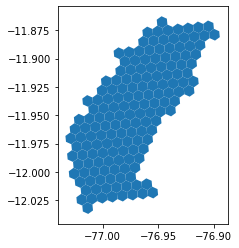

In [29]:
hex_sjl.plot()

Merging both layers

In [30]:
pop_sjl.isna().sum()

latitude           0
longitude          0
population_2015    0
population_2020    0
geometry           0
dtype: int64

In [31]:
hex_sjl.isna().sum()

hex         0
geometry    0
dtype: int64

In [32]:
hex_sjl = up.geom.merge_shape_hex(
    hex_sjl, 
    pop_sjl, 
    how='inner', 
    op='intersects', 
    agg={'population_2020': 'sum'}
)

In [33]:
hex_sjl.isna().sum()

hex                 0
geometry            0
population_2020    22
dtype: int64

In [34]:
hex_sjl.fillna(0, inplace=True)

<AxesSubplot:>

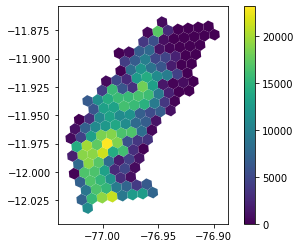

In [35]:
hex_sjl.plot(column='population_2020', legend=True)

## Distance matrix calculation

To estimate the cost for our FLP, we will use walking travel time. For this we need to

* Setup the OSRM server
* Get the distance matrix
* Shutdown the server

In [72]:
up.routing.start_osrm_server('peru', 'south-america', 'foot')

Starting server ...
Server was started succesfully


To compute_osrm_dist_matrix we need Point geometry (We are going to use each hexagon centroid)

In [73]:
hex_sjl_centroids = hex_sjl.copy() # Copy original gdf
hex_sjl_centroids.geometry = hex_sjl_centroids.geometry.centroid # Replace Polygon for Point/Polygon Centroidcandidates = candidates[candidates['aforo'] >= 500]

/home/claudio/Documents/urbanpy/.env/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [74]:
print(hex_sjl_centroids.shape[0], candidates.shape[0])

160 1812


Now we are going to calculate the distance matrix. This operation is time expensive this may take several minutes ...

In [ ]:
try:
    cost_mat = np.load('output/distance_matrix.npy')
except:
    distance, duration = up.routing.compute_osrm_dist_matrix(hex_sjl_centroids, candidates)
    cost_mat = duration.T
    np.save('output/distance_matrix.npy', cost_mat) # save the file to avoid running this function again    

In [76]:
up.routing.stop_osrm_server('peru', 'south-america', 'foot')

Server was stoped succesfully


### Constructing PuLP sets and variables

Set an the number of facilities to be activated

In [77]:
p = merc.shape[0]+12

In [78]:
p

135

Build the facility and customer set as lists, as per PuLP requirements

In [79]:
candidates = candidates.reset_index(drop=True)

In [80]:
customers = list(hex_sjl_centroids.index)
facilities = [f'FAC_{i}' for i in candidates.index]

Now we create dictionaries for the demand and cost, associating each customer (hexagon) to the demand (population) and each facility (park/pitch) the respective cost (travel time) to each customer 

In [81]:
demand = {i: hex_sjl.loc[i, 'population_2020'] for i in hex_sjl.index}

In [82]:
cost_dict = {facilities[i]: {customers[j]: cost_mat[i][j] for j in hex_sjl.index} for i in candidates.index}

In [83]:
capacity = {facilities[i]: markets.loc[i, 'aforo'] for i in merc.id}

Create problem variable for PuLP

In [84]:
prob = LpProblem('FLP_Markets_SJL', LpMinimize)

We create the decision variable $x_{ij}$, representing the percentage of service assigned from a facility to a customer, setting 0 as the lower bound

In [85]:
x = LpVariable.dicts('Service', 
                    [(i,j) for j in customers for i in facilities],
                    0)

Now we create the decision variable to activate a facility $y_i$

In [86]:
y = LpVariable.dicts('Activation',
                     facilities,
                     0,1, LpBinary)

Setting the objective function $$ \sum_{i=1}^{n} \sum_{j=1}^{m} d_{j} c_{ij} x_{ij} $$

In [87]:
prob += lpSum(lpSum(demand[j]*cost_dict[i][j]*x[i,j] for i in facilities) for j in customers)

We add the first constraint $$ \sum_{i=1}^{n} x_{ij} = 1 \quad \forall j \in \text{Customers}$$

In [88]:
for j in customers:
    prob += lpSum(x[i,j] for i in facilities) == 1

Adding the second constraint $$ \sum_{i=1}^{n} y_{i} = p $$

In [89]:
prob += lpSum(y[i] for i in facilities) == p

Third constraint $$ x_{i,j} ≤ y_{i} \quad \forall i \in \text{Facilities} \quad \forall j \in \text{Customers}$$

In [90]:
for i in facilities:
    for j in customers:
        prob += x[i,j] <= y[i]

We need to keep the markets active, focusing on activating only additional facilities (avoid selecting already active markets)

In [91]:
merc.shape

(123, 5)

In [92]:
for i in facilities[1231:]:
    prob += y[i] == 1

Finally, as to maintain proper social distancing, we set a capacity constraint $$ \sum_{j=1}^{m} x_{ij} ≤ c_{i} \quad \forall i \in \text{Facilities}$$

In [93]:
for i in capacity:
    prob += lpSum(x[i,j] for j in customers) <= capacity[i]

Solve (a custom solver may be added in the solve method)

In [94]:
prob.solve()

-1

Check solution status

In [95]:
print("Status:", LpStatus[prob.status])

Status: Infeasible


Obtain the demand assignments

In [96]:
x_vars = [[0 for j in range(len(customers))] for i in range(len(facilities))]

for v in prob.variables():
    if 'Activation' not in v.name:
        i, j = re.findall('\d+', v.name)
        x_vars[int(i)][int(j)] = v.varValue

In [97]:
y_vars = np.zeros_like(facilities)

for v in prob.variables():
    if 'Activation' in v.name:
        ix = int(re.findall('\d+', v.name)[0])
        y_vars[ix] = v.varValue

y_vars = y_vars.astype(float)

In [98]:
x_vars, y_vars = np.array(x_vars), np.array(y_vars)

Add some flags useful for visualization purposes

In [99]:
candidates['is_active'] = y_vars

In [100]:
candidates['is_market'] = 0

In [101]:
candidates.loc[1231:, 'is_market'] = 1

In [102]:
candidates[(candidates['is_active'] == 1) & (candidates['is_market'] == 0)].shape

(0, 7)

In [103]:
candidates.reset_index(drop=True, inplace=True)

Save results

In [104]:
# Raw
np.save('output/assignments.npy', x_vars)
np.save('output/facilities.npy', y_vars)

In [106]:
# For viz
candidates.to_file('output/facilities')